<a href="https://colab.research.google.com/github/jesusfchavarro/sentimentAnalysis/blob/master/sentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analizador de opiniones de profesores

Jesus Felipe Chavarro Muñoz

El sitio https://losestudiantes.co/ registra las opiniones de estudiantes sobre profesores de diferentes universidades. Los estudiantes expresan su opinión como una entrada en lenguaje natural, y posteriormente asignan una calificación númerica al profesor.

**Problema:** se requiere pasar las opiniones en lenguaje natural de los estudiantes a una calificación cualitativa. Para esto se usara la opinion y la calificaciones que se tienen en la pagina *los estudiantes* 

Este problema se encuentra en lo que se conoce como *analisis de sentimiento* o *sentiment analysis*, este tipo de problemas se puede reducir a un problema de clasificación de las opiniones en donde se tiene las clases opinion 'positiva' y opinion 'negativa'. 

En nuestro caso esto no bastaria ya que queremos tener una calificación numerica de 1 a 5. En este caso se podria generalisar lo anterior a un problema de clasificación multi-clase en donde se tendrian las clases: 1,2,3,4,5, esto se conoce como *Fine-grained Sentiment Analysis*. Sin embargo esto se vuelve inviable ya que la clasificación no es discreta, se tendrian que tener las clases 1.1 o 1.11 y esto generaria muchas clases y con esto se aumentaria la tasa de errores. 

Ahora es el momento de preguntarnos ¿realemente queremos irnos al detalle con una calificación numerica no discreta? ¿vale la pena agregar tanta complexidad al modelo(aumentando el error y el desarrollo)? Mi respuesta es no, con las aproximaciones discretas de las calificaciones se puede obtener un promedio por profesor mas detallado y evitamos el aumento del error por agregar mas clases o usar otro metodo mas general. 

## State of the art 

En una breve investigación se encontraron utiles los siguientes articulos:

1.   [Linking Numerical Scores with Sentiment Analysis of
students’ teaching](http://aaee.net.au/wp-content/uploads/2018/10/AAEE2016-Cunningham-Nelson_Baktashmotlagh_Boles-Student_evaluation_survey_numerical_scores_and_sentiment_analysis_links.pdf): En este articulo intenta solventar nuestro mismo problema, para esto ellos hicieron unas encuestas con una escala de Likert de 5 puntos de varias preguntas. Ellos provaron con Regresion linear, Bayes y Support Vector Machines(SVM). El que mejor resultado dio fue SVM con una precisión de 57.7%.  
2.   [Fine-grained Sentiment Classification using BERT](https://arxiv.org/pdf/1910.03474.pdf): Se hace un Fine-grained Sentiment Analysis con BERT (Bidirectional Encoder Representations from Transformers) que es una herramienta de NLP creada por google. En este paper se logro una precisión del 55%. 

Aparte de estos 2 articulos academicos se uso el siguiente articulo/tutorial: 

3.   [Fine-grained Sentiment Analysis](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4) en este explican algunos preprocesamientos necesarios entre otras cosas.



## Experimento

El experimento propuesto sera adaptar el SVM y el BERT usados en los articulos mencionados para hacer el analisis de sentimiento y comparar los resultados. para esto se hara una particion de 75/25 y se construira una matriz de confusion para ver en que clase la clasificación es mejor o peor.

## Datos

Para la obtención de los datos se hizo un scrapper que recolectara todas las opiniones de los estudiantes con su respectiva calificación. Esto se hizo con la erramienta de Cheerio y el analizador de trafico de Chrome. Con esto se logro obtener 39319 opiniones, lamentablemente aproximadamente 10000 no tenian una opinion y solo tenian la calificación numerica. Despues de remover esto quedaron 29653 opiniones.

In [0]:
import pandas as pd

df = pd.read_csv('opiniones.txt')
print(df.shape)
df = df.dropna()
print(df.shape)
df['calificacion'] = df['calificacion'].astype(int).astype('category')

df


(39319, 2)
(29653, 2)


,opinion,calificacion
0,Es la profesora más comprensiva y tierna del m...,5
1,Es una persona que transmite su pasión por lo ...,5
2,La mejor profesora que he tenido. Más que una ...,5
3,"Es una profesora demasiado querida, ha sido de...",5
4,"Muy desorganizada, aunque al final calificó la...",3
...,...,...
39309,"Desorganizado, califica duro,",3
39314,"Es un gran maestro, una persona preocupada por...",5
39315,"Al ser una materia de corte histórico, el cont...",4
39317,El profesor nunca explica otras epistemologías...,2


Se parten los datos en 85/25 con la ayuda de sklearn, el dataset de entrenamiento quedo finalmente en 22239.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['opinion'], df['calificacion'], test_size=0.25)

train = pd.DataFrame()
test = pd.DataFrame()

train.loc[:,'opinion'] = X_train
train.loc[:,'calificacion'] = y_train

test.loc[:,'opinion'] = X_test
test.loc[:,'calificacion'] = y_test

print(train.shape)
print(test.shape)


(22239, 2)
(7414, 2)


### balance

Como se puede notar en la siguiente grafica el dataset no se encuentra balanceado teniendo la gran mayoria de calificaciones en el 4 y el 5.

Text(0, 0.5, 'Label')

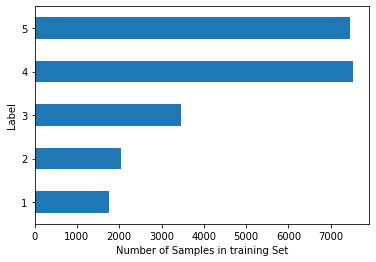

In [0]:
import matplotlib.pyplot as plt
ax = train['calificacion'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

Text(0, 0.5, 'Label')

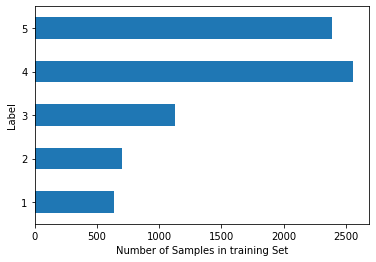

In [0]:
import matplotlib.pyplot as plt
ax = test['calificacion'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in test Set")
ax.set_ylabel("Label")

In [0]:
from sklearn.metrics import f1_score, accuracy_score

class Base:
    """Base class that houses common utilities for reading in test data
    and calculating model accuracy and F1 scores.
    """
    def __init__(self) -> None:
        pass

    def read_data(self, fname: str, lower_case: bool=False) -> pd.DataFrame:
        "Read in test data into a Pandas DataFrame"
        df = pd.read_csv(fname)
        df['calificacion'] = df['calificacion'].str.replace('__label__', '')
        # Categorical data type for truth labels
        df['calificacion'] = df['calificacion'].astype(int).astype('category')
        # Optional lowercase for test data (if model was trained on lowercased text)
        if lower_case:
            df['opinion'] = df['opinion'].str.lower()
        return df

    def accuracy(self, df: pd.DataFrame) -> None:
        "Prediction accuracy (percentage) and F1 score"
        acc = accuracy_score(df['calificacion'], df['pred'])*100
        f1 = f1_score(df['calificacion'], df['pred'], average='macro')
        print("Accuracy: {}\nMacro F1-score: {}".format(acc, f1))

from sklearn.metrics import confusion_matrix
import numpy as np


def plot_confusion_matrix(y_true, y_pred, 
                          classes=[1, 2, 3, 4, 5],
                          normalize=False,
                          cmap=plt.cm.YlOrBr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (Adapted from scikit-learn docs).
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label with respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Set alignment of tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

## SVM

Adaptando un poco el codigo de 3, se logra implementar un analizador de sentimiento con una SVM con una precision del 56.6%.


In [0]:
class SVMSentiment(Base):
    """Predict fine-grained sentiment scores using a sklearn 
    linear Support Vector Machine (SVM) pipeline."""
    def __init__(self, model_file: str=None) -> None:
        super().__init__()
        from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
        from sklearn.linear_model import SGDClassifier
        from sklearn.pipeline import Pipeline
        self.pipeline = Pipeline(
            [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(
                    loss='hinge',
                    penalty='l2',
                    alpha=1e-3,
                    random_state=42,
                    max_iter=100,
                    learning_rate='optimal',
                    tol=None,
                )),
            ]
        )

    def predict(self, train_data: str, test_data: str, lower_case: bool=False) -> pd.DataFrame:
        "Train model using sklearn pipeline"
        learner = self.pipeline.fit(train_data['opinion'], train_data['calificacion'])
        # Predict class labels using the learner and output DataFrame
        test_data['pred'] = learner.predict(test_data['opinion'])
        return test_data

In [0]:
model = SVMSentiment()
    
result = model.predict(train, test)
model.accuracy(result)

Accuracy: 56.676557863501486
Macro F1-score: 0.5341766702342944


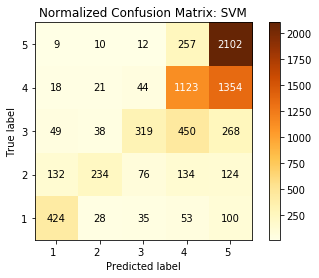

In [0]:
fig, ax = plot_confusion_matrix(result['calificacion'], result['pred'])
ax.set_title("Normalized Confusion Matrix: SVM")
fig.show()


### Analisis
Aunque se haya logrado una precision muy buena con la matriz de confusion se logra ver que el desbalance del dataset sesga un poco los datos a las clases 5 y 4. Para jugar un poco con el dataset se quita la mitad de las clases 4 y 5 para tener un dataset un poco mas balanceado. El test set no se balancea.

Text(0, 0.5, 'Label')

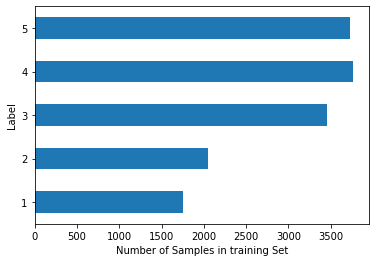

In [0]:
idx = train[train['calificacion']==5][::2].index
train_balance = train.drop(idx)
idx = train[train['calificacion']==4][::2].index
train_balance = train_balance.drop(idx)

ax = train_balance['calificacion'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

Aunque se balanceo quitando aproximadamente 8000 opiniones de las clases 4 y 5 no se vio mayor cambio en el comportamiento general del modelo. Cabe resaltar que con el dataset balanceado se noto una mejora en la precision, con mayor detalle en el acierto de la clase 3

In [0]:
result = model.predict(train_balance, test)
model.accuracy(result)

Accuracy: 57.85001348799569
Macro F1-score: 0.559904481299108


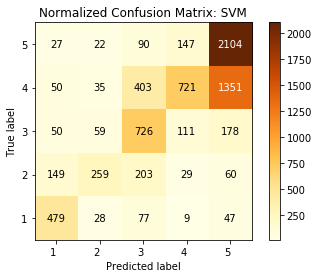

In [0]:
fig, ax = plot_confusion_matrix(result['calificacion'], result['pred'])
ax.set_title("Normalized Confusion Matrix: SVM")
fig.show()

## BERT (BETO)

Dado que BERT es un sistema pre-entrenado para hacer analisis de sentimiento(en ingles) utilizaremos [BETO](https://github.com/dccuchile/beto) que es la version entrenada en español.

In [0]:
!pip install transformers
!pip install tqdm

!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

--2020-02-14 12:02:39--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409871727 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz.1’

pytorch_weights.tar 100%[===================>] 390.88M  7.97MB/s    in 43s     

2020-02-14 12:03:24 (9.11 MB/s) - ‘pytorch_weights.tar.gz.1’ saved [409871727/409871727]

--2020-02-14 12:03:25--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242349 (237K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>] 236.67K   222KB/s    in

In [0]:
import torch
from transformers import BertForMaskedLM, BertTokenizer, BertConfig, BertModel

config = BertConfig.from_pretrained("pytorch/")
config.num_labels = 5
    
model = BertModel.from_pretrained("pytorch/", config=config)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31002, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [0]:
from tqdm import tqdm


def train_one_epoch(model, lossfn, optimizer, dataset, batch_size=32):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for batch, labels in tqdm(generator):
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        loss, logits = model(batch, labels=labels)
        err = lossfn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred_labels = torch.argmax(logits, axis=1)
        train_acc += (pred_labels == labels).sum().item()
    train_loss /= len(dataset)
    train_acc /= len(dataset)
    return train_loss, train_acc


def evaluate_one_epoch(model, lossfn, optimizer, dataset, batch_size=32):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    model.eval()
    loss, acc = 0.0, 0.0
    with torch.no_grad():
        for batch, labels in tqdm(generator):
            batch, labels = batch.to(device), labels.to(device)
            logits = model(batch)[0]
            error = lossfn(logits, labels)
            loss += error.item()
            pred_labels = torch.argmax(logits, axis=1)
            acc += (pred_labels == labels).sum().item()
    loss /= len(dataset)
    acc /= len(dataset)
    return loss, acc


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
lossfn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

trainset = train[:int(train.shape[0]*0.7)]
devset = train[int(train.shape[0]*0.7):]
testset = test

epochs = 30
batch_size = 32
for epoch in range(1, epochs):
    train_loss, train_acc = train_one_epoch(
        model, lossfn, optimizer, trainset, batch_size=batch_size
    )
    val_loss, val_acc = evaluate_one_epoch(
        model, lossfn, optimizer, devset, batch_size=batch_size
    )
    test_loss, test_acc = evaluate_one_epoch(
        model, lossfn, optimizer, testset, batch_size=batch_size
    )
    logger.info(f"epoch={epoch}")
    logger.info(
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, test_loss={test_loss:.4f}"
    )
    logger.info(
        f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}, test_acc={test_acc:.3f}"
    )
    if save:
        label = "binary" if binary else "fine"
        nodes = "root" if root else "all"
        torch.save(model, f"{bert}__{nodes}__{label}__e{epoch}.pickle")

logger.success("Done!")



  0%|          | 0/487 [00:00<?, ?it/s]

KeyError: ignored

In [0]:
train[int(train.shape[0]*0.7):]



,opinion,calificacion
33294,Excleente profesor. Se preocupa pro el rendimi...,4
21684,"Excelente profesora, la clase es demasiado int...",5
29261,"En general es un buen profesor, aunque toca es...",4
19852,Maria Rosa es la mejor profesora de todas las ...,5
33312,"Aunque la clase es divertida, se omiten muchos...",3
...,...,...
8234,Muy mala profesora. No sabe explicar y es dema...,1
12313,El mejor profesor del departamento.,5
33869,No explica muy bien los temas y sus clases son...,2
38306,"Excelente profesor, muy gracioso y entendido e...",5


## Fuentes
1. [Linking Numerical Scores with Sentiment Analysis of
students’ teaching](http://aaee.net.au/wp-content/uploads/2018/10/AAEE2016-Cunningham-Nelson_Baktashmotlagh_Boles-Student_evaluation_survey_numerical_scores_and_sentiment_analysis_links.pdf) 2016
2. [Fine-grained Sentiment Classification using BERT](https://arxiv.org/pdf/1910.03474.pdf) 2019
3. [Fine-grained Sentiment Analysis](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)